In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Make Phantom

In [2]:

voxel_size = np.array([0.0005, 0.0005, 0.0005])
surface_mesh = o3d.io.read_triangle_mesh(f"{parent}/assets/breast_phantom/breast_surface.ply")
body_mask = phantom_builder.voxelize(voxel_size[0], mesh=surface_mesh) 

In [3]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (voxel_size[0], voxel_size[0], voxel_size[0]),
                               matrix_dims = body_mask.shape,
                               baseline = (1540, 1000),
                               seed = 5678,
                               )

skin = tissue.Tissue(name='skin', c=1624, rho=1109, sigma=1.3, scale=0.00001, label=1)
fat = tissue.Tissue(name='fat', c=1440.2, rho=911, sigma=40, scale=0.0003, label=2)
ligament = tissue.Tissue(name='ligament', c=1750, rho=1142, sigma=30, scale=0.0001, label=3)
gland = tissue.Tissue(name='gland', c=1564, rho=1041, sigma=40, scale=0.0002, label=4)
tumor = tissue.Tissue(name='tumor', c=1500, rho=911, sigma=0, scale=0.0001, label=5)
muscle = tissue.Tissue(name='muscle', c=1580, rho=1090, sigma=4, scale=0.001, label=6)

kidney_file_dir = f"{parent}/assets/breast_phantom/"
kidney_tissue_list = [skin, fat, skin, gland, gland, ligament, muscle, tumor]

test_phantom.build_organ_from_mesh(surface_mesh, voxel_size[0], kidney_tissue_list, dir_path = kidney_file_dir)
test_phantom.set_default_tissue('water')

Added skin
Added fat
Added skin
Added gland
Added gland
Added ligament
Added muscle
Added tumor


In [4]:
test_phantom.matrix_dims = np.array(test_phantom.mask.shape)
test = test_phantom.get_complete()

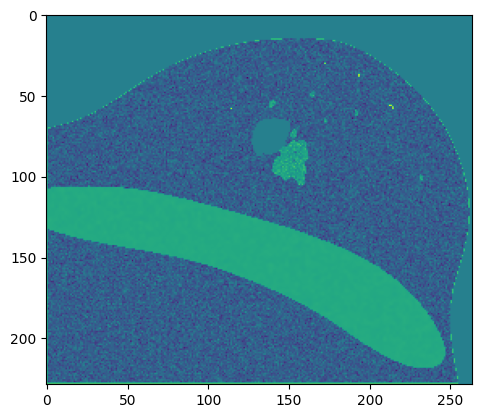

In [5]:
index = 140
plt.imshow(test[0, :, :, index])
bm = np.flip(body_mask, axis=0)
# plt.imshow(body_mask[:,:, index] * 1000, alpha=0.2, cmap='Reds_r')

# Set up simulation

In [6]:
num_transducers = 1

transducers = [transducer.Focused(max_frequency = 2.5e6,
                                  elements = 128, 
                                  width = 20e-3,
                                  height =  20e-3,
                                  sensor_sampling_scheme = 'not_centroid', 
                                  sweep = [np.pi/2,np.pi/2],
                                  ray_num = [64,64],
                                  imaging_ndims = 3,
                                  focus_azimuth = 20e-3,
                                  focus_elevation = 40e-3) for i in range(num_transducers)]


for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [7]:
transform1 = geometry.Transform([0,0,0], [0,0,0])
transform2 = geometry.Transform([0,0,0], [0,0,0])
transform3 = geometry.Transform([0,0,0], [0,0,0])
transform = transform1 * transform2 * transform3
position = [-0.05,0.01,0]
transform.translation = (transform1 * transform2).apply_to_point(position, inverse=False)
test_transducer_set.assign_pose(0, transform)

In [8]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

In [9]:
np.mean(test_sensor.sensor_coords, axis=0) / voxel_size + np.array(test.shape[1:])/2

array([ 14.49999851, 151.99999955, 141.5       ])

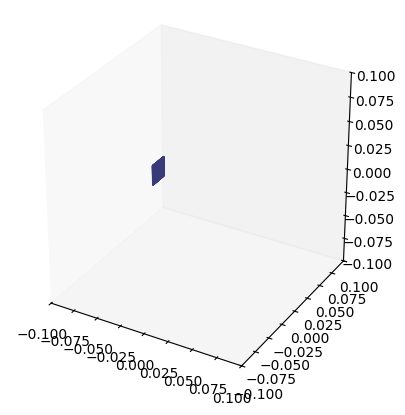

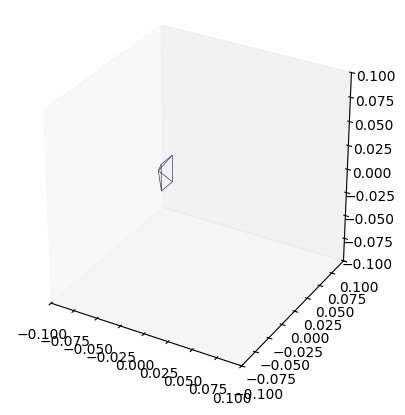

In [10]:
test_transducer_set.plot_transducer_coords()
test_transducer_set.plot_transducer_fovs()

In [11]:
simprops = simulation.SimProperties(
                grid_size   = (60e-3,20e-3,20e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (8,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [12]:
test_experiment = experiment.Experiment(
                 simulation_path = f'{parent}/experiment_files/breast_experiment_02',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

test_experiment.save()

In [13]:
(np.mean(test_sensor.sensor_coords, axis=0) / voxel_size + np.array(test.shape[1:]))[2]//2

141.0

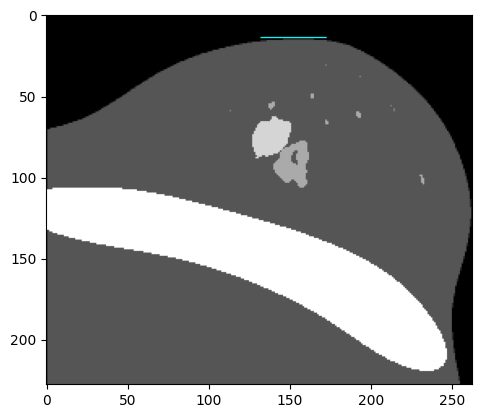

In [14]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), int((np.mean(test_sensor.sensor_coords, axis=0) / voxel_size + np.array(test.shape[1:]))[2]//2)])

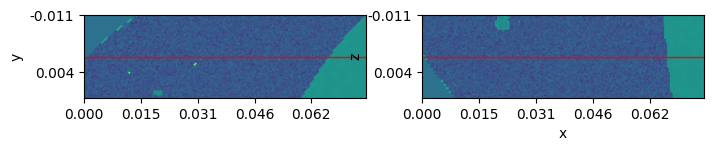

In [15]:
test_experiment.plot_ray_path(31)

# Run Simulation

In [16]:
test_experiment = experiment.Experiment.load(f'{parent}/experiment_files/breast_experiment_02')
test_experiment.run(dry=True)

Number of simulation results (496) is less than the expected number of simulation results (4096), are you sure the simulation finished running?
dry run of simulation


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


In [17]:
test_experiment.run(repeat=False)

running with 3 workers

preparation for sim 2296 completed in 33.31 seconds
preparation for sim  248 completed in 33.53 seconds
preparation for sim 2297 completed in 33.90 seconds
preparation for sim  249 completed in 34.61 seconds
preparation for sim 2298 completed in 32.96 seconds
preparation for sim  250 completed in 33.05 seconds
simulation          2296 completed in 136.44 seconds
simulation           248 completed in 144.19 seconds
preparation for sim 2299 completed in 33.38 seconds
preparation for sim  251 completed in 33.93 seconds
simulation          2297 completed in 144.17 seconds
simulation           249 completed in 136.16 seconds
preparation for sim 2300 completed in 33.19 seconds
preparation for sim  252 completed in 33.01 seconds
simulation          2298 completed in 128.76 seconds
simulation           250 completed in 117.94 seconds
preparation for sim 2301 completed in 33.07 seconds
preparation for sim  253 completed in 32.39 seconds
simulation          2299 completed

# Reconstruction

In [ ]:
test_experiment.add_results()

In [ ]:
test_reconstruction = reconstruction.DAS(experiment=test_experiment)

In [ ]:
signals = test_reconstruction.get_signals(dimensions=2, matsize=128, downsample=0.5, workers=16, tgc=10)

100%|██████████| 64/64 [00:15<00:00,  4.20it/s]
1it [00:00,  1.16it/s]


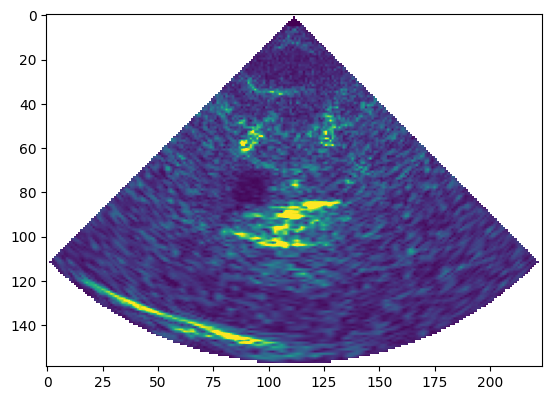

In [ ]:
plt.imshow(signals[0], vmax=200000)
